# Markovic

This notebook shows how to construct an efficient frontier of stocks based on mean variance optimization. 

### Variables

$$
\begin{equation}
C : \textrm{number of stocks}\\
T : \textrm{number of time observations} \\
\boldsymbol{\mu} : \textrm{mean stock return (C x 1)} \\
\boldsymbol{\Sigma} : \textrm{covariance matrix of returns (C x C)} \\
\mu_{targ} : \textrm{target mean return}
\end{equation}
$$

### Global Minimum Variance Portfolio

The weights, mean, and variance of the global minimum variance portfolio are
$$
\begin{equation}
\boldsymbol{w}_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota} \Sigma^{-1} \iota 
= \frac{\Sigma^{-1} \iota }{C}\\
\mu_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota}\mu' \Sigma^{-1} \iota 
= \frac{B}{C}\\
\sigma_{gmv}^2 = \frac{1}{\iota' \Sigma^{-1} \iota}
= \frac{1}{C}
\end{equation}
$$


### Efficient Frontier

The efficient frontier is defined as a linear combination of two portfolios. 
$$
\begin{equation}
\boldsymbol{w} = \lambda \boldsymbol{w}_{mu} + (1-\lambda) \boldsymbol{w}_{gmv} \\
\lambda = \frac{BC\mu_{targ}-B^2}{AC-B^2} \\
\textrm{where}\\
A = \mu' \Sigma^{-1} \mu\\
B = \mu' \Sigma^{-1} \iota\\
C = \iota' \Sigma^{-1} \iota\\
\end{equation} 
$$


In [1]:
from pathlib import Path
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
def preprocess_column_name(column_name):
    column_name = column_name.title().replace(' ','').strip()
    return column_name


## Data Extraction 

### 1. Tickers



In [3]:
rawTickerDataPath = Path('data') / 'nasdaq_screener_1614797288539.csv'
processedTickerDataPath = Path('data') / 'tickers.csv'
selectedColumns = ['Symbol', 'Name', 'MarketCap', 'Country', 'Sector', 'Industry']

if not processedTickerDataPath.exists():
    print('- load raw ticker data')
    tickersDF = pd.read_csv(rawTickerDataPath)
    print('- process raw ticker data')
    tickersDF.columns = [preprocess_column_name(e) for e in tickersDF.columns]
    tickersDF = tickersDF[selectedColumns]
    print('- save processed ticker table')
    tickersDF.to_csv(processedTickerDataPath, index=False)
else:
    print('load processed ticker table')
    tickersDF = pd.read_csv(processedTickerDataPath)


load processed ticker table


### 2. Prices

In [4]:
pricesDataPath = Path('data') / 'prices.csv'
numCompanies = 10

if not pricesDataPath.exists():
    print('get returns from yahoo')
    tickers = tickersDF['Symbol'].tolist()
    tickers = [e for e in tickers if '^' not in e]
    pricesDF = yf.download( 
    tickers = ' '.join(tickers[:numCompanies]),
    period = "1y",
    interval = "1d",
    group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
    )
    pricesDF.to_csv(pricesDataPath, index=False)
else:
    print('load downloaded returns table')
    pricesDF = pd.read_csv(pricesDataPath, header =[0,1])

pricesDF.head(2)


load downloaded returns table


AAP                                                           AAN  \
         Open        High         Low       Close   Adj Close   Volume Open   
0  115.150002  118.300003  114.000000  117.589996  116.860023  1011400  NaN   
1  118.489998  121.089996  117.470001  118.949997  118.211586   774400  NaN   

                  ...  AAIC                                  A             \
  High Low Close  ...   Low Close Adj Close  Volume       Open       High   
0  NaN NaN   NaN  ...  2.51  2.62      2.62  300100  75.620003  75.910004   
1  NaN NaN   NaN  ...  2.58  2.72      2.72  355000  76.349998  76.620003   

                                         
         Low  Close  Adj Close   Volume  
0  74.019997  75.75  75.217224  1654300  
1  75.839996  76.25  75.713707  1295800  

[2 rows x 60 columns]

## Data Analysis

### 1. Tickers : Industry Analysis

In [5]:
print(f"""
Number of unique Sectors : {tickersDF.Sector.unique().size}
Number of unique Industries : {tickersDF.Industry.unique().size}
""")


Number of unique Sectors : 13
Number of unique Industries : 134



### 2. Prices

In [6]:
pricesDF.columns = pd.MultiIndex.from_tuples(pricesDF.columns.swaplevel())
pricesDF = pricesDF['Adj Close']
pricesDF = pricesDF.T[pricesDF.isnull().sum().eq(0)].T
pricesDF.head(2)

,AAP,ABC,AAT,ABBV,ABB,AB,AA,AAIC,A
0,116.860023,87.168907,25.159243,79.563316,16.928318,18.238653,7.15,2.62,75.217224
1,118.211586,89.213005,26.718382,80.610329,17.424208,19.062746,7.37,2.72,75.713707


In [7]:
print(f"""
number of time steps: {pricesDF.shape[0]}
number of companies: {pricesDF.shape[1]}
number of companies with full history: {pricesDF.isnull().sum().eq(0).sum()}
number of companies with no history: {pricesDF.notnull().sum().eq(0).sum()}
""")



number of time steps: 252
number of companies: 9
number of companies with full history: 9
number of companies with no history: 0



## Get stock prices and Returns

In [8]:
returnsDF = pricesDF.pct_change().iloc[1:]
logReturnsDF = np.log(1+returnsDF)

p = pricesDF.to_numpy() # prices
r = returnsDF.to_numpy() # returns
r_log = np.log(1+r) # log returns

T, C = p.shape # time periods, number of companies

u = r_log.mean(0)
Sigma = np.cov(r_log.T)
iota = np.ones((C,1))


### Realised returns

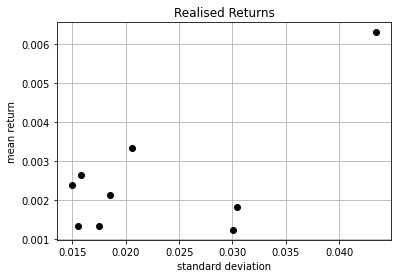

In [9]:
vol = np.sqrt(Sigma.diagonal())
x = vol
y = u

plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.title('Realised Returns')
plt.grid()
plt.show()


### Efficient Frontier

Creating the efficient frontier plot

In [10]:
A = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), u)
B = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), iota)
C = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), iota)
D = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), u)

w_gmv = 1 / C * np.matmul(np.linalg.inv(Sigma), iota).reshape(-1,1)
u_gmv = B / C
std_gmv = np.sqrt(1 / C)

w_mu = 1 / D * np.matmul(np.linalg.inv(Sigma), u).reshape(-1,1)


In [11]:
print(f"""
Global Minimum Variance Portfolio
mean : {u_gmv[0][0]}
std : {std_gmv[0][0]}
""")


Global Minimum Variance Portfolio
mean : 0.0017017414368200084
std : 0.01064234805005081



In [12]:
c = 1.5
x = []
y = []
for u_targ in np.linspace(1/c*min(u), c*max(u), 200).tolist():
    _lambda = (B * C * u_targ - B * B) / (A * C - B * B)
    w = _lambda * w_mu + (1-_lambda) * w_gmv
    sigma = np.sqrt(np.matmul(np.matmul(w.T, Sigma), w))[0][0]
    x.append(sigma)
    y.append(u_targ)


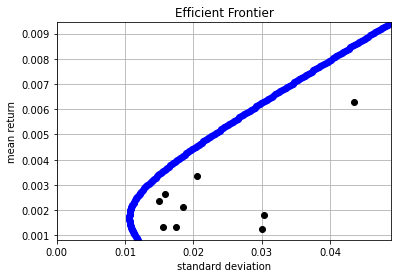

In [13]:
# plt.style.use('seaborn-whitegrid')    
vol = np.sqrt(Sigma.diagonal()).tolist()
min_sigma = min(x + vol)
max_sigma = max(x + vol)
min_return = min(y)
max_return = max(y)
plt.plot(x, y, 'o', color='blue')
x = vol
y = u
plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.xlim([0, max_sigma])
plt.ylim([min_return, max_return])
plt.title('Efficient Frontier')
plt.grid()
plt.show()


## Principal Component Analysis (PCA)

Investigate the effect of applying PCA on the covariance matrix.

### - Stocks are highly correlated

/home/bart/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 1.0)

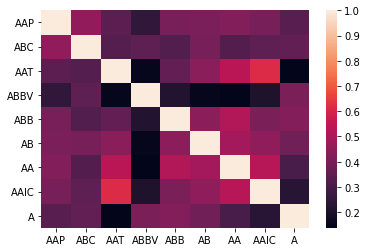

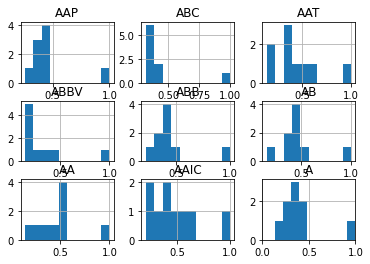

In [29]:
numStocks = 10

sns.heatmap(returnsDF[returnsDF.columns[:numStocks]].corr());
returnsDF[returnsDF.columns[:numStocks]].corr().hist();
plt.xlim([0,1])

In [19]:
import numpy as np

from sklearn.decomposition import PCA

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=10)
pca.fit(r_log)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=9 with svd_solver='full'

In [ ]:
w_pca = pca.components_[0]
w_pca *= 1/w_pca.sum()
u_pca = np.matmul(w_pca, u)
sigma_pca = np.sqrt(np.matmul(np.matmul(w_pca, Sigma), w_pca))
u_pca, sigma_pca

### Get industry prices and returns (equally weighted)

In [107]:
r_log

array([[ 0.04895609, -0.00464753,  0.00664454, ...,  0.0474022 ,
         0.03681696,  0.01556284],
       [-0.04721462, -0.07997799, -0.03710371, ..., -0.04773705,
        -0.04126801, -0.02536055],
       [-0.02389742, -0.07689377, -0.03496865, ...,  0.03326505,
        -0.07005556, -0.05409107],
       ...,
       [-0.00677098,  0.05647416,  0.00491401, ..., -0.01655076,
         0.00106916, -0.01008631],
       [-0.02871639,  0.11365329, -0.00738004, ...,  0.00753351,
         0.03949601,  0.03995151],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
industries equally weighted industry (I*C) * returns (C*T) = I*C*R
(C*R)


In [ ]:
G*C*T inner product G*C*T